## Load data

Fill in path to ConnectivityMatrix object below.

Also fill in path to output figure and the title to give it.

In [1]:
import numpy
import pandas

import conntility

from scipy.spatial import distance
from matplotlib import pyplot as plt


fn = "/gpfs/bbp.cscs.ch/project/proj159/home/barros/conn_matrix/Rat_623um_squared_struc_conmat_filtered_compressed.h5"
fn_out = "touch_count_probs_rat.pdf"
figure_title = "Rat: Structural"

M = conntility.ConnectivityMatrix.from_h5(fn)
if M.is_multigraph:
    M = M.compress()

## Parameters

In [2]:
max_touch_count = 10 # Plot up to that number of touches
dist_bin_sz = 50 # Size of distance bins in um
min_num_edges_last_bin = 5000 # For distance bins: How many edges must be in the last one at least? Determines distance cutoff
min_num_samples_p = 500 # For the plotting: Probabilities based on fewer than this number of samples are set to NaN (masked out)

cols_xyz = ["x", "y", "z"] # Names of coordinates for distance calculation

## Calculations

In [3]:
# Add distance and distance bin information to the edges.
# The table of edges must contains columns "bin" (distance bin index) and "count" (number of touches). 

sum_deltas = numpy.zeros(len(M.edges))

for axis in cols_xyz:
    prop = M.edge_associated_vertex_properties(axis)
    delta = prop["row"].values - prop["col"].values
    sum_deltas += (delta ** 2)

M.add_edge_property("distance", numpy.sqrt(sum_deltas))

# Linear distance bins (for now)
tgt_percentile = 100 * (1.0 - min_num_edges_last_bin / len(M.edges)) # This way, the last distance bin will contain the specified number of edges.
max_dist = numpy.percentile(M.edges["distance"], tgt_percentile) # There are min_num_edges_last_bin edges beyond that distance!

dbins = numpy.arange(0, max_dist, dist_bin_sz)
dbins[0] = 1E-9
dbin_ids = numpy.arange(len(dbins))
bin_centers = dbins + 0.5 * numpy.mean(numpy.diff(dbins))
M.add_edge_property("bin", numpy.digitize(M.edges["distance"], bins=dbins) - 1)

print(M.edges["bin"].value_counts())

bin
1     161854
2     127908
3      98827
4      84190
5      72423
6      64592
7      58219
8      52725
0      50927
9      49428
10     45463
11     38856
12     32948
13     28331
14     25647
15     24303
16     23317
17     21646
18     19922
19     18461
20     16965
21     15020
22     11824
23      8604
24      6888
25      5842
31      5687
26      4729
27      4036
28      3397
29      2862
30      2274
Name: count, dtype: int64


In [4]:
master_table = M.edges.groupby("bin")["count"].value_counts().unstack("count", fill_value=0)

In [5]:
D = distance.squareform(distance.pdist(M.vertices[cols_xyz]))
D = numpy.digitize(D.flatten(), bins=dbins) - 1
Dcounts = pandas.Series(D, name="bin").value_counts().drop(-1)

master_table[0] = Dcounts - master_table.sum(axis=1) # Zero touches pair count
master_table = master_table.sort_index(axis=1, ascending=False)

In [6]:
P_geq = master_table.cumsum(axis=1) # Number of samples with touch count >= a threshold
P_gt = P_geq.copy() # We shift it by one index -> Number of samples with touch count > a threshold
P_gt.columns = P_gt.columns - 1

condP = P_gt.div(P_geq, fill_value=0).drop(columns=-1)
condP[P_geq < min_num_samples_p] = numpy.NaN
condP.columns = condP.columns + 1 # Now index is the touch number: 1 indicating first touch, etc.

## Plotting

Text(0, 0.5, 'Touch #')

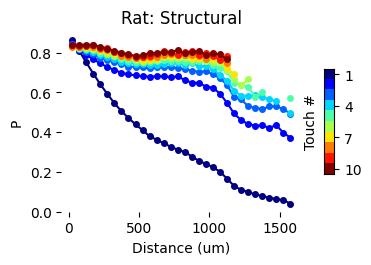

In [7]:
from matplotlib import cm

cmap = cm.jet

touches = numpy.arange(1, max_touch_count + 1)
touch_col_v = numpy.linspace(0, 1, len(touches))

fig = plt.figure(figsize=(3, 2))
ax = fig.add_axes([0.05, 0.05, 0.8, 0.9])

for t, v in zip(touches, touch_col_v):
    col = cmap(v)
    ax.plot(bin_centers, condP[t], color=col, label="Touch #{0}".format(t), marker='o', ms=4)

ax.set_frame_on(False)
ax.set_xlabel("Distance (um)")
ax.set_ylabel("P")
ax.set_title(figure_title)

ax = fig.add_axes([0.925, 0.15, 0.035, 0.7])
ax.imshow(cmap(touch_col_v).reshape((-1, 1, 4)))
ax.yaxis.tick_right()
ax.set_xticks([])
ax.set_yticks(numpy.arange(1, max_touch_count + 1, 3) - 1)
ax.set_yticklabels(numpy.arange(1, max_touch_count + 1, 3))
ax.set_ylabel("Touch #")

fig.savefig(fn_out)